# Interface residue ML prediction. 10th attempt, just use carbon angles from Zander to the "dense" notebook and dataset 
100 point.

Added all carbon angles, using the `zander.py` script

## Load modules and packages

In [1]:
from sklearn import tree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

from sklearn import datasets
from sklearn.decomposition import PCA
import random

In [3]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

## Load data, standard dictionaries and lists
Also:
- Removes empty columns from One-hot encoded target array. (Some standard residues in dict and list do not occur in dataset)
- Store an int version of One-hot encoded target array.
- Scale input features
- Split in training and test sets

In [4]:
res2num = {"ALA": 0, "ASX": 1, "CYS": 2, "ASP": 3, "GLU": 4, "PHE": 5, "GLY": 6, "HIS": 7,
 "ILE": 8, "LYS": 9, "LEU": 10, "MET": 11, "ASN": 12, "PRO": 13, "GLN": 14,
  "ARG": 15, "SER": 16, "THR": 17, "SEC": 18, "VAL": 19, "TRP": 20, "XAA": 21,
   "TYR": 22, "GLX": 23}

old_names = ["ALA", "ASX", "CYS", "ASP", "GLU", "PHE", "GLY", "HIS",
 "ILE", "LYS", "LEU", "MET", "ASN", "PRO", "GLN",
  "ARG", "SER", "THR", "SEC", "VAL", "TRP", "XAA",
   "TYR", "GLX"]

In [5]:
X2 = np.load('../dataset/dihedral_train_angles.npy')

ctypes_array = np.zeros((len(X2), len(res2num)))
for i, t in enumerate(X2[:,4]):
    ctypes_array[i, int(t)] = 1.0
    
X2 = np.concatenate((X2[:,0:4], ctypes_array), axis=1)

In [6]:
# Load features and targets
y = np.load('../dataset/dihedral_train_target.npy')
n_obs = y.shape[0]


# Select non zero from old_names using y first
nonzero_index = (~np.all(y == 0, axis = 0)).nonzero()[0]
names = []
for i in nonzero_index:
    names.append(old_names[i])
    
# Then remove zero columns from 'y'
y = y[:,~np.all(y == 0, axis = 0)]

(array([ 979.,  980.,  906.,  929.,  953.,  931.,  941.,  931.,  838.,
         815.,  882.,  783.,  711.,  777.,  780.,  857., 1009.,  976.,
        1110., 1171., 1235., 1356., 1241., 1024.,  970.,  924.,  800.,
         817.,  844.,  743.,  745.,  668.,  769.,  711.,  709.,  695.,
         731.,  766.,  795.,  757.,  813.,  766.,  785.,  845.,  890.,
         956.,  969.,  939.,  982., 1043.]),
 array([-3.14143181e+00, -3.01577213e+00, -2.89011245e+00, -2.76445277e+00,
        -2.63879309e+00, -2.51313341e+00, -2.38747373e+00, -2.26181405e+00,
        -2.13615437e+00, -2.01049469e+00, -1.88483500e+00, -1.75917532e+00,
        -1.63351564e+00, -1.50785596e+00, -1.38219628e+00, -1.25653660e+00,
        -1.13087692e+00, -1.00521724e+00, -8.79557562e-01, -7.53897882e-01,
        -6.28238201e-01, -5.02578521e-01, -3.76918840e-01, -2.51259160e-01,
        -1.25599480e-01,  6.02006912e-05,  1.25719881e-01,  2.51379561e-01,
         3.77039242e-01,  5.02698922e-01,  6.28358603e-01,  7.540182

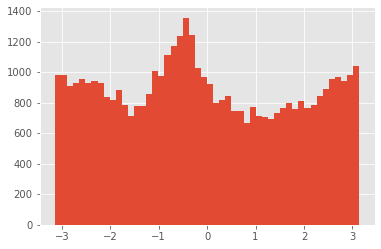

In [7]:
# Sanity check to see if carbon angles make sense. Look at distances.
plt.hist(X2[:,1], bins = 50)

In [8]:
# Added carbon angles, so now 33 instead of 29 features per point

In [12]:
# Just check the ranges of features
feature_count =0
for i in range(X2.shape[-1]):
    print(feature_count, np.min(X2[:,i]), np.max(X2[:,i]))
    feature_count+=1

0 0.8154110312461853 43.71630859375
1 -3.1414318084716797 3.141552209854126
2 -3.1414794921875 3.1415469646453857
3 0.017618995159864426 3.134652853012085
4 0.0 1.0
5 0.0 0.0
6 0.0 1.0
7 0.0 1.0
8 0.0 1.0
9 0.0 1.0
10 0.0 1.0
11 0.0 1.0
12 0.0 1.0
13 0.0 1.0
14 0.0 1.0
15 0.0 1.0
16 0.0 1.0
17 0.0 1.0
18 0.0 1.0
19 0.0 1.0
20 0.0 1.0
21 0.0 1.0
22 0.0 0.0
23 0.0 1.0
24 0.0 1.0
25 0.0 0.0
26 0.0 1.0
27 0.0 0.0


In [14]:
# Get integer values from one-hot encoding
y_int = np.array([])
for i in y:
    y_int = np.concatenate((y_int, np.nonzero(i)[0]))

# Save float and unique arrays of y_int
y_float = y_int.astype(np.float32)
unique_y = np.unique(y_float)

In [102]:
# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y_float, test_size=0.2, random_state=2)

In [103]:
def split_point_carbon(arr):
    """Takes original feature array and separately returns the per-point values
    and the opposing carbon angles of the surface you use for prediction."""
    per_point = arr[:,:,0:29]
    carbon_angles = arr[:,1,-28:]
    return per_point, carbon_angles

X_train_p, X_train_c = split_point_carbon(X_train)
X_test_p, X_test_c = split_point_carbon(X_test)

In [112]:
X_train_c = X_train_c[:,~np.all(X_train_c == 0, axis = 0)]
X_test_c = X_test_c[:,~np.all(X_test_c == 0, axis = 0)]

In [113]:
X_temp_train = X_train.reshape(X_train.shape[0],100*int(n_feats))
X_temp_test = X_test.reshape(X_test.shape[0],100*int(n_feats))

ValueError: cannot reshape array of size 203130900 into shape (35637,2900)

## Basic EDA and visualisation
Can a simple tree-based machine learning algorithm predict the residue?

Can PCA or t-SNE already find a separation between data points? I.e., is there something distinguishing the point clouds complementary to residues that does not have to be "learned" during multiple irations?

Furthermore, what how frequently do the respective residue types occur at interfaces? One needs to deal with imbalances in the dataset.

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=15, random_state=0, class_weight= "balanced")
clf.fit(X_temp_train, y_train)

y_RF_pred = clf.predict(X_temp_test)

In [28]:
len(np.unique(y_RF_pred))

20

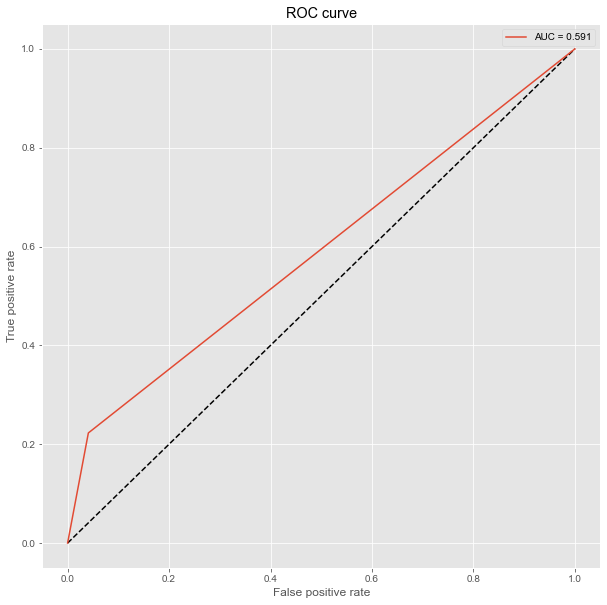

In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()
y_RF_onehot = enc.fit_transform(y_RF_pred[:, np.newaxis]).toarray()
with torch.no_grad():
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_RF_onehot.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
sns.set_style("whitegrid")


In [30]:
pca = PCA(n_components=2)
X_r = pca.fit(X_scaled).transform(X_scaled)

print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

explained variance ratio (first two components): [0.17920989 0.08075625]


In [31]:
rgb = []
for y in unique_y:
    col = (random.random(), random.random(), random.random())
    rgb.append(col)
colors = rgb

In [32]:
plt.figure()
lw = 2

<Figure size 432x288 with 0 Axes>

In [33]:
num2res = dict(zip(range(len(names)), names))
y_res_str = pd.Series(y_float).map(lambda x: num2res[x])

'Amino acid counts'

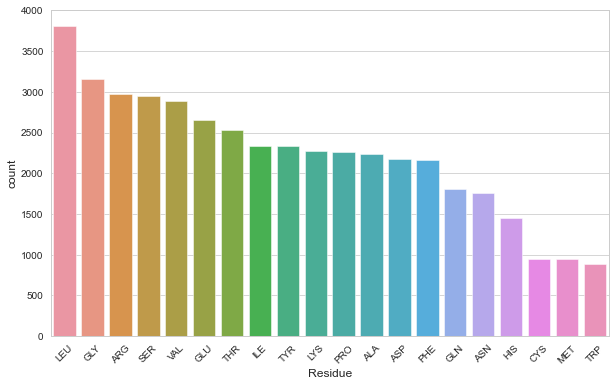

In [34]:
import seaborn as sns
plt.figure(figsize = (10,6))
df = pd.DataFrame(y_res_str)
df.rename(columns={0:'Residue'}, inplace=True)
sns.countplot(x='Residue', data = df, order = y_res_str.value_counts().index)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)

g ="Amino acid counts"
g

Text(0.5, 1.0, 'PCA of AA surface dataset')

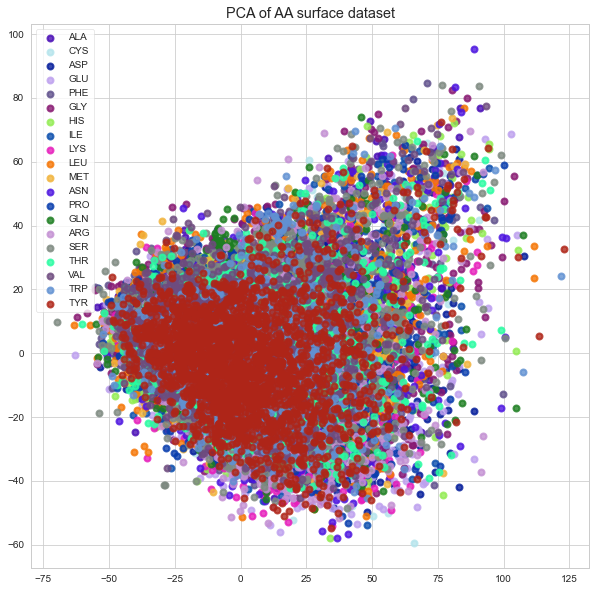

In [35]:
plt.figure(figsize = (10,10))
for color, i, name in zip(colors, unique_y, names[0:20]):
    plt.scatter(X_r[y_int == i, 0], X_r[y_int == i, 1], color = color, alpha=.8, lw=lw,
                label=name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of AA surface dataset')

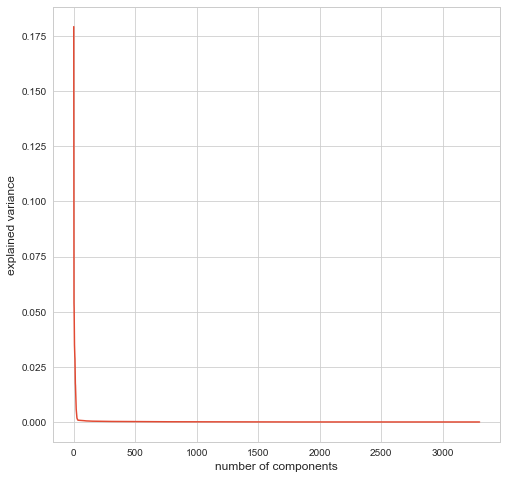

In [36]:
plt.figure(figsize = (8,8))
pca = PCA().fit(X_scaled)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('explained variance');

In [24]:
# Add contibution of variables to two PC's and form a single array
contrib_arr = np.add(abs(pca.components_)[0], abs(pca.components_)[1])

In [25]:
contrib_arr.shape

(2900,)

In [30]:
indices = (-abs(contrib_arr)).argsort()[:250]

In [31]:
(indices < 1450).sum()

150

NameError: name 'indices' is not defined

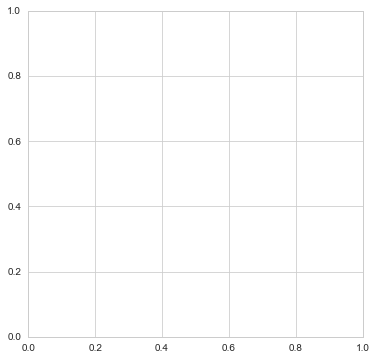

In [37]:
fig, ax = plt.subplots(1, figsize=(6,6))
sns.countplot(indices%33)

NameError: name 'contrib_arr' is not defined

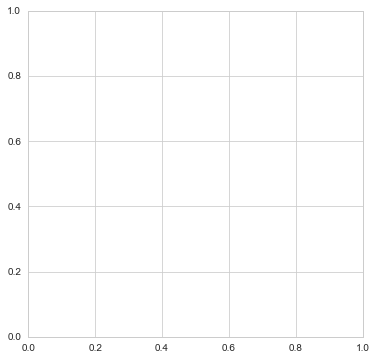

In [38]:
fig, axs = plt.subplots(1, figsize=(6,6))
var_contribution = abs(np.sort(-contrib_arr))
var_pca_df = pd.DataFrame(zip(range(len(var_contribution)), var_contribution))
var_pca_df = var_pca_df.rename(columns={0:"Ranking",1:"Contribution"})
sns.lineplot(data=var_pca_df, x='Ranking', y='Contribution')

In [ ]:
X_train.shape

## Code for 100 points

In [114]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

In [115]:
class Model(nn.Module):
    def __init__(self, input_dim, angle_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Conv1d(input_dim, 50, 1, stride=1)
        self.layer2 = nn.Linear(100, 20)
        self.drop_layer = nn.Dropout(p=0.5)
        self.layer3 = nn.Linear(1000, 100)
        self.layerA = nn.Linear(angle_dim,1)
        self.layer4 = nn.Linear(101, 20)
        
        
 
    def forward(self, x, y):
        x = torch.transpose(x, 1,2)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = x.view(-1,50*20)
        x = self.drop_layer(x) # dropout module
        x = F.relu(self.layer3(x))
        y = F.relu(self.layerA(y))
        x = torch.cat((x, y), 1)
        x = F.sigmoid(self.layer4(x))
        
        return x

In [116]:
class_sample_count = np.unique(y_train, return_counts=True)[1]
weight = 1. / class_sample_count
res_weight = Variable(torch.from_numpy(weight)).float()

In [117]:
res_weight

tensor([0.0006, 0.0013, 0.0006, 0.0005, 0.0006, 0.0004, 0.0008, 0.0005, 0.0005,
        0.0003, 0.0013, 0.0007, 0.0006, 0.0007, 0.0004, 0.0004, 0.0005, 0.0004,
        0.0014, 0.0005])

In [118]:
model     = Model(X_train_p.shape[2], X_train_c.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn   = nn.CrossEntropyLoss(weight=res_weight)
model

Model(
  (layer1): Conv1d(29, 50, kernel_size=(1,), stride=(1,))
  (layer2): Linear(in_features=100, out_features=20, bias=True)
  (drop_layer): Dropout(p=0.5, inplace=False)
  (layer3): Linear(in_features=1000, out_features=100, bias=True)
  (layerA): Linear(in_features=24, out_features=1, bias=True)
  (layer4): Linear(in_features=101, out_features=20, bias=True)
)

In [119]:
import torch.nn.functional as F
import tqdm

EPOCHS  = 100
X_train_p = Variable(torch.from_numpy(X_train_p)).float()
X_train_c = Variable(torch.from_numpy(X_train_c)).float()

y_train = Variable(torch.from_numpy(y_train)).long()

X_test_p  = Variable(torch.from_numpy(X_test_p)).float()
X_test_c  = Variable(torch.from_numpy(X_test_c)).float()

y_test  = Variable(torch.from_numpy(y_test)).long()

In [120]:
loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train_p, X_train_c)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test_p, X_test_c)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

  0%|          | 0/100 [00:00<?, ?it/s]/Users/maxjansen/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 100/100 [08:27<00:00,  5.08s/it]


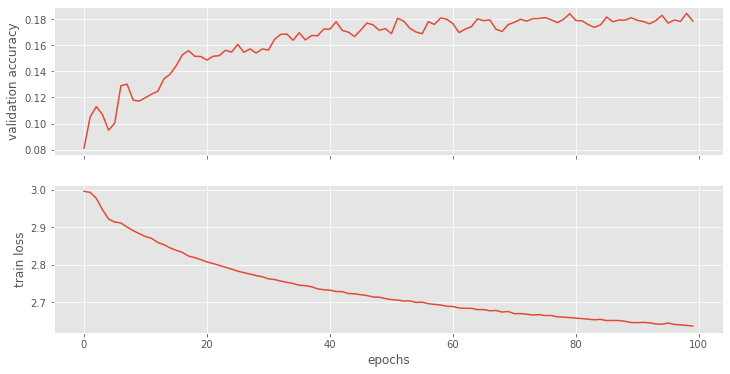

In [122]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("train loss")
ax2.set_xlabel("epochs");

/Users/maxjansen/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


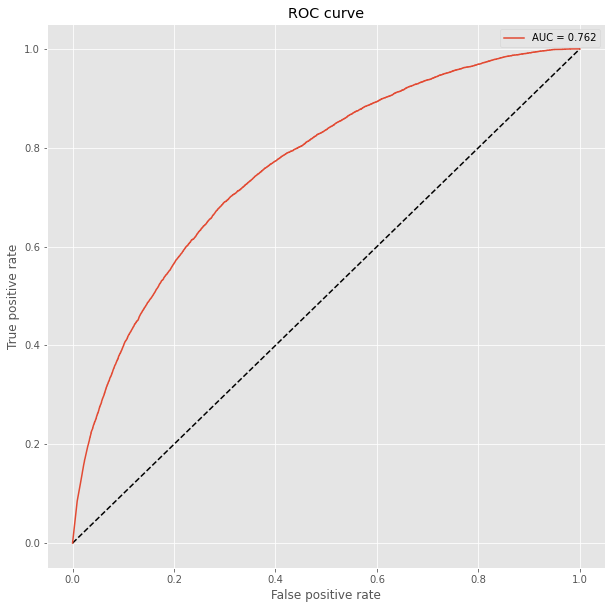

In [123]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test_p, X_test_c).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

In [124]:
len(np.unique(y_test))

20

TypeError: forward() missing 1 required positional argument: 'y'

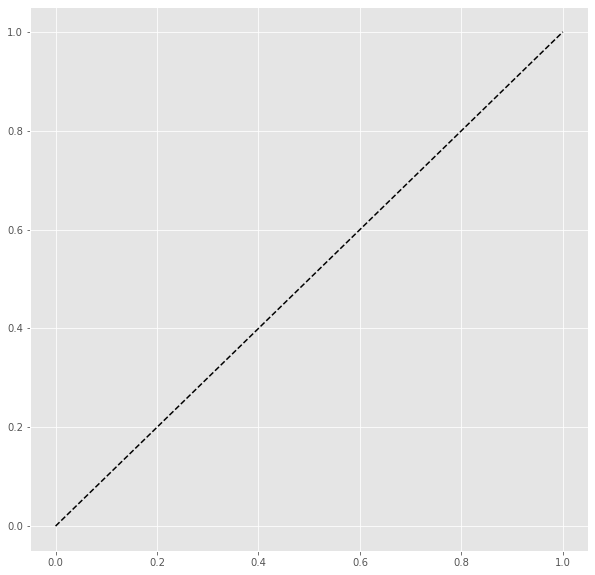

In [125]:
# Do a ROC plot for each amino acid
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()
for i in range(len(np.unique(y_test))):
    
    with torch.no_grad():
        y_pre = (model(X_test)[y_test == i]).numpy()
        Y_one = Y_onehot[y_test == i]
        fpr, tpr, threshold = roc_curve(Y_one.ravel(), y_pre.ravel())
    
    plt.plot(fpr, tpr, label=names[i] + ' AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

## Some quick and dirty, but useful scripts to calculate the overall accuracy.


In [41]:
pred_int = np.argmax(y_pred, 1)

In [110]:
np.argsort(y_pred, axis=1)

array([[ 7, 17, 16, ..., 12,  5,  0],
       [18,  7,  6, ...,  5,  2,  1],
       [ 5, 15,  0, ..., 18,  7, 17],
       ...,
       [ 5,  2,  0, ..., 17, 18, 16],
       [ 5,  0, 16, ..., 10,  9,  3],
       [ 7,  9, 17, ...,  2,  0,  5]])

In [135]:
np.isin(np.array(y_test), (np.argsort(y_pred, axis=1)[:,-3:]))

array([ True,  True,  True, ...,  True,  True,  True])

In [141]:
(((np.argsort(y_pred, axis=1)[:,-3:]) == np.array(y_test)[:, None]).any(axis = 1)).sum() / len(y_test) * 100

45.18518518518518

In [59]:
((np.array(y_test) == pred_int).sum())/len(y_test) * 100

18.35016835016835

In [64]:
y_pred

array([[1.0000000e+00, 5.5313722e-06, 1.3981301e-04, ..., 7.5578812e-22,
        5.4894203e-06, 2.5281152e-13],
       [2.5603262e-01, 9.9990368e-01, 9.8809367e-01, ..., 1.1766690e-03,
        9.5494420e-12, 1.5445901e-02],
       [4.3319023e-16, 3.2800633e-06, 1.6423321e-10, ..., 9.9999940e-01,
        9.4622916e-01, 1.2514292e-05],
       ...,
       [2.1641395e-06, 1.5672582e-01, 2.0808554e-06, ..., 9.7698826e-01,
        9.8225361e-01, 2.3739491e-02],
       [6.0639774e-12, 2.1354858e-06, 5.3436840e-03, ..., 4.4143424e-04,
        6.5744865e-07, 5.6660134e-02],
       [7.1687186e-01, 3.8651004e-05, 5.7864273e-01, ..., 1.8498532e-08,
        8.1001463e-07, 1.1659653e-01]], dtype=float32)

## 2021.11.02 This model gave the best results yet! (again) Not a major improvement, though

In [61]:
np.amin(np.amax(y_pred, axis=1))

0.29916552

In [62]:
y_pred_max =np.zeros((len(y_pred),len(y_pred[0])))
for count,i in enumerate(y_pred):
    y_pred_max[count, np.argmax(i)] = 1

In [63]:
# One-hot to int
def onehot_int(one_hot):
    y_int = np.array([])
    for i in one_hot:
        y_int = np.concatenate((y_int, np.nonzero(i)[0]))
    return y_int

In [64]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(onehot_int(Y_onehot), onehot_int(y_pred_max))

NameError: name 'cm' is not defined

In [65]:
norm_cm = cm/cm.sum(axis =1,keepdims=True)

In [66]:
norm_cm =norm_cm*100

In [67]:
def plot_confusion_matrix(data, labels):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    sns.set(color_codes=True)
    plt.figure(1, figsize=(14, 14))
 
    plt.title("Confusion Matrix")
 
    sns.set(font_scale=1.4)
    ax = sns.heatmap(data, annot=True, cmap="coolwarm", cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
    plt.close

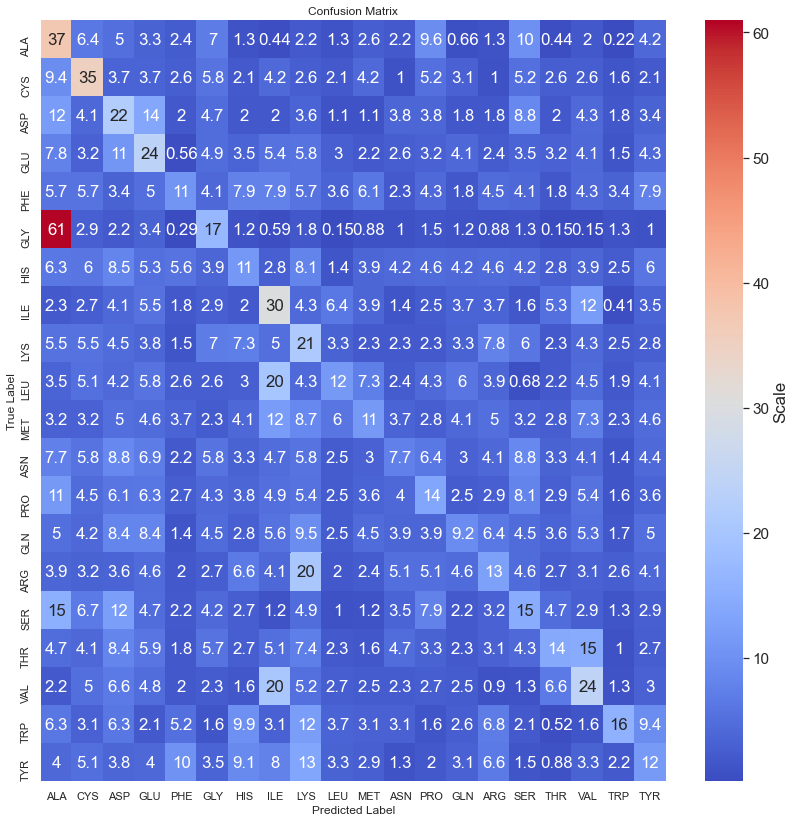

In [68]:
plot_confusion_matrix(norm_cm, names)